In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data = pd.read_csv('data/Mental Illness Survey 1.csv')
data.head(10)

,Respondent ID,Collector ID,Start Date,End Date,IP Address,Email Address,First Name,Last Name,Custom Data 1,I identify as having a mental illness,Education,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am currently employed at least part-time,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,Total length of any gaps in my resume in months.,Annual income (including any social welfare programs) in USD,I am unemployed,I read outside of work and school,Annual income from social welfare programs,I receive food stamps,I am on section 8 housing,How many times were you hospitalized for your mental illness,I have one of the following issues in addition to my illness,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Age,Gender,Household Income,Region,Device Type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Response,Response,Response,Response,Open-Ended Response,Response,Response,Response,Response,Response,Open-Ended Response,Open-Ended Response,Response,Response,Open-Ended Response,Response,Response,Open-Ended Response,Lack of concentration,Anxiety,Depression,Obsessive thinking,Mood swings,Panic attacks,Compulsive behavior,Tiredness,Response,Response,Response,Response,Response
1,6.630447e+09,168522804.0,01/15/2018 03:45:16 AM,01/15/2018 03:48:24 AM,NaN,NaN,NaN,NaN,06f645d7ea5af372d50a62bd17,No,High School or GED,No,No,0,No,No,Yes,No,Yes,24,35,Yes,Yes,0,No,No,0,Lack of concentration,Anxiety,Depression,Obsessive thinking,NaN,Panic attacks,NaN,NaN,30-44,Male,"$25,000-$49,999",Mountain,Android Phone / Tablet
2,6.630410e+09,168522804.0,01/15/2018 03:17:52 AM,01/15/2018 03:18:57 AM,NaN,NaN,NaN,NaN,abca2776418ff1fe24bb85e21f,Yes,Some Phd,Yes,No,0,Yes,No,Yes,No,No,1,22,No,Yes,0,No,No,0,Lack of concentration,Anxiety,Depression,NaN,NaN,Panic attacks,NaN,Tiredness,18-29,Male,"$50,000-$74,999",East South Central,MacOS Desktop / Laptop
3,6.630402e+09,168522804.0,01/15/2018 03:10:28 AM,01/15/2018 03:12:49 AM,NaN,NaN,NaN,NaN,3800088cf4e55278b38bbe67f3,No,Completed Undergraduate,Yes,No,0,Yes,No,Yes,No,No,0,100,No,Yes,0,No,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-44,Male,"$150,000-$174,999",Pacific,MacOS Desktop / Laptop
4,6.630335e+09,168522804.0,01/15/2018 02:11:16 AM,01/15/2018 02:12:33 AM,NaN,NaN,NaN,NaN,84585803a3cec189f89fe43d44,No,Some Undergraduate,Yes,No,NaN,No,No,Yes,Yes,Yes,11,0,Yes,Yes,0,No,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-44,Male,"$25,000-$49,999",New England,Windows Desktop / Laptop
5,6.630290e+09,168522804.0,01/15/2018 01:24:12 AM,01/15/2018 01:26:34 AM,NaN,NaN,NaN,NaN,4b4faaaa7eaff01549233044bd,Yes,Completed Undergraduate,Yes,Yes,35,Yes,Yes,Yes,No,Yes,33,32,No,Yes,30,No,No,4,Lack of concentration,Anxiety,Depression,Obsessive thinking,Mood swings,Panic attacks,Compulsive behavior,Tiredness,30-44,Male,"$25,000-$49,999",East North Central,iOS Phone / Tablet
6,6.630246e+09,168522804.0,01/15/2018 12:40:03 AM,01/15/2018 12:42:26 AM,NaN,NaN,NaN,NaN,4cc5941a4f2572aa7c4a708008,No,High School or GED,Yes,No,0,Yes,No,Yes,Yes,No,0,0,No,Yes,0,No,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-44,Male,"$0-$9,999",South Atlantic,Android Phone / Tablet
7,6.630236e+09,168522804.0,01/15/2018 12:30:16 AM,01/15/2018 12:31:51 AM,NaN,NaN,NaN,NaN,c06b5c9b4f73dccbdf2af2f67f,No,Some Undergraduate,Yes,No,0,Yes,No,Yes,No,No,0,1,No,Yes,0,No,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18-29,Male,"$100,000-$124,999",Middle Atlantic,Windows Desktop / Laptop
8,6.630216e+09,168522804.0,01/15/2018 12:08:46 AM,01/15/2018 12:11:24 AM,NaN,NaN,NaN,NaN,40ca6ac2f0a327e96d797478a4,Yes,Some Undergraduate,Yes,No,0,Yes,No,Yes,Yes,No,0,11,No,Yes,0,No,No,0,Lack of concentration,Anxiety,Depression,NaN,NaN,Panic attacks,Compulsive behavior,Tiredness,18-29,Male,"$100,000-$124,999",Middle Atlantic,Windows Desktop / Laptop
9,6.630198e+09,168522804.0,01/14/2018 11:50:35 PM,01/14/2018 11:52:27

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 40 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Respondent ID                                                 334 non-null    float64
 1   Collector ID                                                  334 non-null    float64
 2   Start Date                                                    334 non-null    object 
 3   End Date                                                      334 non-null    object 
 4   IP Address                                                    0 non-null      float64
 5   Email Address                                                 0 non-null      float64
 6   First Name                                                    0 non-null      float64
 7   Last Name                                                     0 non-nul

# Cleaning & Preprocessing
So we see that this data needs quite a bit of cleaning.
- deal with secondary header
- unnamed cols
- cols to drop
- Handle nulls
- convert cols to appropriate dtype
- a lot of categorical data
    - label encoding
    - one hot encoding

## Rename & Drop cols
- The collector id is the same for all records, so drop. 
- I don't need the respondent id since they are all unique and we can use index as the id
- IP Address, Email Address, First Name, and Last Name are all full of nulls
- I have no definition for 'Custom Data 1' and it is not apparent what it represents
- Some features seem to be asking very similar things and are likely colinear
    - 'I have been hospitalized before for my mental illness' and 'How many days were you hospitalized for your mental illness"
    - 'I have a gap in my resume' and 'Total length of any gaps in my resume in months.'
    - 'I am currently employed at least part-time' and 'I am unemployed'
- consider dropping 'Annual income (including any social welfare programs) in USD' and 'Annual income from social welfare programs' if target is about unemployment since these cols may lead to an overfit model
    


In [4]:
# Name Unnamed cols
data.rename(columns={'Unnamed: 28':'Anxiety',
                     'Unnamed: 29':'Depression',
                     'Unnamed: 30':'Obsessive_thinking',
                     'Unnamed: 31':'Mood_swings',
                     'Unnamed: 32':'Panic_attacks',
                     'Unnamed: 33':'Compulsive_behavior',
                     'Unnamed: 34':'Tiredness',
                     data.columns[27] : 'Lack of concentration',
                     data.columns[19] : 'Total gaps in resume in months', # this col name was causing problems so need to rename
                    }, inplace=True)

In [5]:
data.drop(['Respondent ID', 'Collector ID', 'IP Address', 'Email Address', 'First Name', 'Last Name', 'Custom Data 1'], 
          axis=1, inplace=True)

In [6]:
# drop row 0 since it is a secondary header we don't need
data.drop(index=0, axis=0, inplace=True)

In [7]:
# Explore nulls
for col in data.columns:
    if data[col].isnull().sum() != 0:
        print(f'{col} : {data[col].isnull().sum()}')

How many days were you hospitalized for your mental illness : 37
Lack of concentration : 283
Anxiety : 234
Depression : 248
Obsessive_thinking : 292
Mood_swings : 296
Panic_attacks : 285
Compulsive_behavior : 305
Tiredness : 234
Region : 2


## In order to do analysis of the nulls, I need to convert the cols to the appropriate dtypes
    
Some of the null values mean the participant did not endorse a symptom. These should be converted to boolean values before other nulls are handled to avoid confusion between these meaningful null and nulls with unknown meaning.

Then I will convert all cols that have yes/no values to boolean.

Some of the null values mean the participant did not endorse a symptom. These should be converted to boolean values before other nulls are handled to avoid confusion between these meaningful null and nulls with unknown meaning.

In [8]:
symptom_cols = ['Anxiety', 'Depression', 'Obsessive_thinking', 'Mood_swings', 'Panic_attacks', 'Compulsive_behavior', 'Tiredness', 'Lack of concentration']
for col in symptom_cols:
    data[col].fillna(0, inplace=True)
    data[col] = data[col].apply(lambda x : 0 if x==0 else 1)

In [9]:
# get all columns that have Yes and No as values
bool_cols = [col for col in data.columns if all(item in data[col].unique() for item in ['Yes', 'No'])]
bool_cols

<ipython-input-9-6bf0a0b50552>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  bool_cols = [col for col in data.columns if all(item in data[col].unique() for item in ['Yes', 'No'])]


['I identify as having a mental illness',
 'I have my own computer separate from a smart phone',
 'I have been hospitalized before for my mental illness',
 'I am currently employed at least part-time',
 'I am legally disabled',
 'I have my regular access to the internet',
 'I live with my parents',
 'I have a gap in my resume',
 'I am unemployed',
 'I read outside of work and school',
 'I receive food stamps',
 'I am on section 8 housing']

In [10]:
# the LabelBinarizer converts 'yes' and 'no' responsese to 1 and 0
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer()
for col in bool_cols:
    data[col] = le.fit_transform(data[col])

In [11]:
# the remaining cols to deal with are the ones with numeric values but are set as object dtype
convert_to_numeric = ['How many days were you hospitalized for your mental illness',
             'Total gaps in resume in months',
             'Annual income (including any social welfare programs) in USD',
             'Annual income from social welfare programs',
             'How many times were you hospitalized for your mental illness'
            ]

for col in convert_to_numeric:
    data[col] = pd.to_numeric(data[col])

In [12]:
# All cols are of the appropriate dtype now
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 1 to 334
Data columns (total 33 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Start Date                                                    334 non-null    object 
 1   End Date                                                      334 non-null    object 
 2   I identify as having a mental illness                         334 non-null    int64  
 3   Education                                                     334 non-null    object 
 4   I have my own computer separate from a smart phone            334 non-null    int64  
 5   I have been hospitalized before for my mental illness         334 non-null    int64  
 6   How many days were you hospitalized for your mental illness   297 non-null    float64
 7   I am currently employed at least part-time                    334 non-n

### Deal with date conversion

In [13]:
data['Start Date'] = pd.to_datetime(data['Start Date'])
data['End Date'] = pd.to_datetime(data['End Date'])

## Finish dealin with nulls
The remaining nulls are in 'How many days hospitalized...' and 'Region'.

### How many days hospitalized...
Do I impute '..days hospitalized..' or drop? How about comparing it to 'I have been hospitalized before for my mental illness' and if they say they say no to this, replace null with 0. 

Let's look at how many people said they have been hospitalized but had null for how many days hosptitalized. We see just 1 personon (at index 266)

In [14]:
mask_yes_hosp = data['I have been hospitalized before for my mental illness']==1
mask_hosp_days_na = data['How many days were you hospitalized for your mental illness'].isna()
data[mask_yes_hosp & mask_hosp_days_na]

,Start Date,End Date,I identify as having a mental illness,Education,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am currently employed at least part-time,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,Total gaps in resume in months,Annual income (including any social welfare programs) in USD,I am unemployed,I read outside of work and school,Annual income from social welfare programs,I receive food stamps,I am on section 8 housing,How many times were you hospitalized for your mental illness,Lack of concentration,Anxiety,Depression,Obsessive_thinking,Mood_swings,Panic_attacks,Compulsive_behavior,Tiredness,Age,Gender,Household Income,Region,Device Type
266,2018-01-14 06:30:13,2018-01-14 06:40:15,0,Completed Undergraduate,1,1,NaN,0,0,1,0,0,1,10,1,1,10,1,1,69,1,1,1,1,1,1,1,1,30-44,Female,"$25,000-$49,999",Pacific,Android Phone / Tablet


In [15]:
# Since it is a single record, I am going to drop this row.
data.drop(index=266, axis=0, inplace=True)
# reset index since we have dropped 2 rows so far
data.reset_index(inplace=True, drop=True)

Who said they hadn't been hospitalized but reported days in the hosipital?

In [16]:
mask_no_hosp = data['I have been hospitalized before for my mental illness']==0
mask_hosp_days_gt_0 = data['How many days were you hospitalized for your mental illness']>0
data[mask_no_hosp & mask_hosp_days_gt_0]

,Start Date,End Date,I identify as having a mental illness,Education,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am currently employed at least part-time,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,Total gaps in resume in months,Annual income (including any social welfare programs) in USD,I am unemployed,I read outside of work and school,Annual income from social welfare programs,I receive food stamps,I am on section 8 housing,How many times were you hospitalized for your mental illness,Lack of concentration,Anxiety,Depression,Obsessive_thinking,Mood_swings,Panic_attacks,Compulsive_behavior,Tiredness,Age,Gender,Household Income,Region,Device Type
21,2018-01-14 21:50:49,2018-01-14 21:51:30,1,Completed Masters,0,0,20.0,1,0,0,0,0,32,24,0,0,66,0,0,19,0,0,0,0,1,0,0,0,18-29,Male,"$25,000-$49,999",Pacific,Android Phone / Tablet
40,2018-01-14 18:20:09,2018-01-14 18:21:40,1,Completed Undergraduate,0,0,78.0,0,1,1,1,0,22,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,30-44,Male,"$0-$9,999",Middle Atlantic,Android Phone / Tablet
41,2018-01-14 17:44:43,2018-01-14 17:45:46,0,Some Undergraduate,0,0,44.0,0,0,0,0,0,43,49,0,1,3,0,0,3,0,1,0,0,0,0,0,0,30-44,Male,"$0-$9,999",South Atlantic,Windows Desktop / Laptop
67,2018-01-14 13:02:26,2018-01-14 13:04:45,0,Completed Phd,1,0,1.0,0,1,1,0,0,1,40,1,1,1,0,0,0,1,0,0,0,0,0,0,0,30-44,Male,"$25,000-$49,999",West South Central,Windows Desktop / Laptop
70,2018-01-14 12:38:07,2018-01-14 12:39:44,0,Completed Undergraduate,1,0,1.0,1,0,1,0,0,1,14,0,1,2,0,0,0,0,0,0,0,0,0,0,0,> 60,Male,"$50,000-$74,999",East North Central,Windows Desktop / Laptop
88,2018-01-14 11:07:59,2018-01-14 11:09:53,0,Completed Undergraduate,1,0,1.0,0,1,1,0,0,0,10,1,1,25,0,0,0,0,0,0,0,0,0,0,1,> 60,Male,"$25,000-$49,999",South Atlantic,Windows Desktop / Laptop
113,2018-01-14 10:30:06,2018-01-14 10:33:01,0,Completed Undergraduate,1,0,1.0,1,0,1,0,0,0,35,0,1,11,0,0,0,0,0,0,0,0,0,0,0,> 60,Female,"$25,000-$49,999",Mountain,iOS Phone / Tablet
129,2018-01-14 10:08:31,2018-01-14 10:10:44,0,High School or GED,1,0,1.0,1,1,1,0,0,1,35,0,1,0,0,0,0,0,0,0,0,0,0,0,0,> 60,Male,"$25,000-$49,999",South Atlantic,Windows Desktop / Laptop
134,2018-01-14 10:02:17,2018-01-14 10:06:45,0,High School or GED,1,0,99.0,1,0,1,1,1,11,1,0,1,2,0,0,69,0,0,0,0,0,1,1,0,45-60,Female,"$0-$9,999",West South Central,Android Phone / Tablet
139,2018-01-14 09:52:09,2018-01-14 09:54:10,0,Some Undergraduate,1,0,1.0,0,1,1,0,0,1,88,1,1,0,0,0,0,0,0,0,0,0,0,0,0,> 60,Male,"$75,000-$99,999",Middle Atlantic,Windows Desktop / Laptop


There are a lot of rows here. Since the participant took the time to enter a numeric value I am going assume that they made a mistake choosing "No" for "I have been hospitalized..."

So I will change these rows so "I have been hospoitalized..." is endorsed.

In [17]:
idxs = data[mask_no_hosp & mask_hosp_days_gt_0]['I have been hospitalized before for my mental illness'].index
data['I have been hospitalized before for my mental illness'].iloc[idxs] = 1

/home/cgridley/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
data.iloc[idxs]

,Start Date,End Date,I identify as having a mental illness,Education,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am currently employed at least part-time,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,Total gaps in resume in months,Annual income (including any social welfare programs) in USD,I am unemployed,I read outside of work and school,Annual income from social welfare programs,I receive food stamps,I am on section 8 housing,How many times were you hospitalized for your mental illness,Lack of concentration,Anxiety,Depression,Obsessive_thinking,Mood_swings,Panic_attacks,Compulsive_behavior,Tiredness,Age,Gender,Household Income,Region,Device Type
21,2018-01-14 21:50:49,2018-01-14 21:51:30,1,Completed Masters,0,1,20.0,1,0,0,0,0,32,24,0,0,66,0,0,19,0,0,0,0,1,0,0,0,18-29,Male,"$25,000-$49,999",Pacific,Android Phone / Tablet
40,2018-01-14 18:20:09,2018-01-14 18:21:40,1,Completed Undergraduate,0,1,78.0,0,1,1,1,0,22,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,30-44,Male,"$0-$9,999",Middle Atlantic,Android Phone / Tablet
41,2018-01-14 17:44:43,2018-01-14 17:45:46,0,Some Undergraduate,0,1,44.0,0,0,0,0,0,43,49,0,1,3,0,0,3,0,1,0,0,0,0,0,0,30-44,Male,"$0-$9,999",South Atlantic,Windows Desktop / Laptop
67,2018-01-14 13:02:26,2018-01-14 13:04:45,0,Completed Phd,1,1,1.0,0,1,1,0,0,1,40,1,1,1,0,0,0,1,0,0,0,0,0,0,0,30-44,Male,"$25,000-$49,999",West South Central,Windows Desktop / Laptop
70,2018-01-14 12:38:07,2018-01-14 12:39:44,0,Completed Undergraduate,1,1,1.0,1,0,1,0,0,1,14,0,1,2,0,0,0,0,0,0,0,0,0,0,0,> 60,Male,"$50,000-$74,999",East North Central,Windows Desktop / Laptop
88,2018-01-14 11:07:59,2018-01-14 11:09:53,0,Completed Undergraduate,1,1,1.0,0,1,1,0,0,0,10,1,1,25,0,0,0,0,0,0,0,0,0,0,1,> 60,Male,"$25,000-$49,999",South Atlantic,Windows Desktop / Laptop
113,2018-01-14 10:30:06,2018-01-14 10:33:01,0,Completed Undergraduate,1,1,1.0,1,0,1,0,0,0,35,0,1,11,0,0,0,0,0,0,0,0,0,0,0,> 60,Female,"$25,000-$49,999",Mountain,iOS Phone / Tablet
129,2018-01-14 10:08:31,2018-01-14 10:10:44,0,High School or GED,1,1,1.0,1,1,1,0,0,1,35,0,1,0,0,0,0,0,0,0,0,0,0,0,0,> 60,Male,"$25,000-$49,999",South Atlantic,Windows Desktop / Laptop
134,2018-01-14 10:02:17,2018-01-14 10:06:45,0,High School or GED,1,1,99.0,1,0,1,1,1,11,1,0,1,2,0,0,69,0,0,0,0,0,1,1,0,45-60,Female,"$0-$9,999",West South Central,Android Phone / Tablet
139,2018-01-14 09:52:09,2018-01-14 09:54:10,0,Some Undergraduate,1,1,1.0,0,1,1,0,0,1,88,1,1,0,0,0,0,0,0,0,0,0,0,0,0,> 60,Male,"$75,000-$99,999",Middle Atlantic,Windows Desktop / Laptop


Checking to see if anyone said they had a hospital stay and had null for number of days in hospital

In [19]:
mask_days_hosp_na = data['How many days were you hospitalized for your mental illness'].isna()
data[mask_days_hosp_na & mask_yes_hosp]

<ipython-input-19-762192605c42>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[mask_days_hosp_na & mask_yes_hosp]


,Start Date,End Date,I identify as having a mental illness,Education,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am currently employed at least part-time,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,Total gaps in resume in months,Annual income (including any social welfare programs) in USD,I am unemployed,I read outside of work and school,Annual income from social welfare programs,I receive food stamps,I am on section 8 housing,How many times were you hospitalized for your mental illness,Lack of concentration,Anxiety,Depression,Obsessive_thinking,Mood_swings,Panic_attacks,Compulsive_behavior,Tiredness,Age,Gender,Household Income,Region,Device Type


In [20]:
# no rows had null for "Number of days hospitalized" and Yes for "I have been hospitalized" 
# so it is reasonable to replace these null values with 0
data['How many days were you hospitalized for your mental illness'].fillna(0, inplace=True)

In [21]:
data['How many days were you hospitalized for your mental illness'].isna().sum()

0

## Region nulls
The only remaining nulls are in the region col. There are only 2, so I will drop these as I would like to see if the Region feature has any significance in prediction.

In [22]:
data.dropna(axis=1, inplace=True)
data.reset_index(inplace=True, drop=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 32 columns):
 #   Column                                                        Non-Null Count  Dtype         
---  ------                                                        --------------  -----         
 0   Start Date                                                    333 non-null    datetime64[ns]
 1   End Date                                                      333 non-null    datetime64[ns]
 2   I identify as having a mental illness                         333 non-null    int64         
 3   Education                                                     333 non-null    object        
 4   I have my own computer separate from a smart phone            333 non-null    int64         
 5   I have been hospitalized before for my mental illness         333 non-null    int64         
 6   How many days were you hospitalized for your mental illness   333 non-null    float64       
 7   I am cur

### OneHot Encode Categorical Features

In [24]:
from sklearn.preprocessing import OneHotEncoder

cat_features = [col for col in data.columns if data[col].dtype=='object']
oh_encoder = OneHotEncoder(sparse=False)
oh_data = oh_encoder.fit_transform(data[cat_features])
oh_data.shape

(333, 30)

In [25]:
# create column headers for onehot encoded data
col_headers = []
for i, cat in enumerate(oh_encoder.categories_):
    for label in cat:
        col_headers.append(cat_features[i] + '_' + label)
        
oh_df = pd.DataFrame(columns=col_headers, data=oh_data)
oh_df.head()

,Education_Completed Masters,Education_Completed Phd,Education_Completed Undergraduate,Education_High School or GED,Education_Some Phd,Education_Some Undergraduate,Education_Some highschool,Education_Some Masters,Age_18-29,Age_30-44,Age_45-60,Age_> 60,Gender_Female,Gender_Male,"Household Income_$0-$9,999","Household Income_$10,000-$24,999","Household Income_$100,000-$124,999","Household Income_$125,000-$149,999","Household Income_$150,000-$174,999","Household Income_$175,000-$199,999","Household Income_$200,000+","Household Income_$25,000-$49,999","Household Income_$50,000-$74,999","Household Income_$75,000-$99,999",Household Income_Prefer not to answer,Device Type_Android Phone / Tablet,Device Type_MacOS Desktop / Laptop,Device Type_Other,Device Type_Windows Desktop / Laptop,Device Type_iOS Phone / Tablet
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
# drop cat features from original dataframe and add encoded features
encoded_df = data.drop(columns=cat_features, axis=1)
encoded_df= pd.concat([encoded_df, oh_df], axis=1)

,Start Date,End Date,I identify as having a mental illness,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am currently employed at least part-time,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,Total gaps in resume in months,Annual income (including any social welfare programs) in USD,I am unemployed,I read outside of work and school,Annual income from social welfare programs,I receive food stamps,I am on section 8 housing,How many times were you hospitalized for your mental illness,Lack of concentration,Anxiety,Depression,Obsessive_thinking,Mood_swings,Panic_attacks,Compulsive_behavior,Tiredness,Education_Completed Masters,Education_Completed Phd,Education_Completed Undergraduate,Education_High School or GED,Education_Some Phd,Education_Some Undergraduate,Education_Some highschool,Education_Some Masters,Age_18-29,Age_30-44,Age_45-60,Age_> 60,Gender_Female,Gender_Male,"Household Income_$0-$9,999","Household Income_$10,000-$24,999","Household Income_$100,000-$124,999","Household Income_$125,000-$149,999","Household Income_$150,000-$174,999","Household Income_$175,000-$199,999","Household Income_$200,000+","Household Income_$25,000-$49,999","Household Income_$50,000-$74,999","Household Income_$75,000-$99,999",Household Income_Prefer not to answer,Device Type_Android Phone / Tablet,Device Type_MacOS Desktop / Laptop,Device Type_Other,Device Type_Windows Desktop / Laptop,Device Type_iOS Phone / Tablet
0,2018-01-15 03:45:16,2018-01-15 03:48:24,0,0,0,0.0,0,0,1,0,1,24,35,1,1,0,0,0,0,1,1,1,1,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2018-01-15 03:17:52,2018-01-15 03:18:57,1,1,0,0.0,1,0,1,0,0,1,22,0,1,0,0,0,0,1,1,1,0,0,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2018-01-15 03:10:28,2018-01-15 03:12:49,0,1,0,0.0,1,0,1,0,0,0,100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2018-01-15 02:11:16,2018-01-15 02:12:33,0,1,0,0.0,0,0,1,1,1,11,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2018-01-15 01:24:12,2018-01-15 01:26:34,1,1,1,35.0,1,1,1,0,1,33,32,0,1,30,0,0,4,1,1,1,1,1,1,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Feature Engineering
- Create col that is the measure of how long it took a person to complete the survey in seconds - perhaps there is a relationship between mental health symptoms reported and time to complete survey

In [32]:
encoded_df['time_to_complete'] = encoded_df['End Date'] - encoded_df['Start Date']
encoded_df['time_to_complete'] = encoded_df['time_to_complete'].apply(lambda x : x.total_seconds())
encoded_df.drop(['Start Date', 'End Date'b], axis=1, inplace=True)
encoded_df.head()

,I identify as having a mental illness,I have my own computer separate from a smart phone,I have been hospitalized before for my mental illness,How many days were you hospitalized for your mental illness,I am currently employed at least part-time,I am legally disabled,I have my regular access to the internet,I live with my parents,I have a gap in my resume,Total gaps in resume in months,Annual income (including any social welfare programs) in USD,I am unemployed,I read outside of work and school,Annual income from social welfare programs,I receive food stamps,I am on section 8 housing,How many times were you hospitalized for your mental illness,Lack of concentration,Anxiety,Depression,Obsessive_thinking,Mood_swings,Panic_attacks,Compulsive_behavior,Tiredness,Education_Completed Masters,Education_Completed Phd,Education_Completed Undergraduate,Education_High School or GED,Education_Some Phd,Education_Some Undergraduate,Education_Some highschool,Education_Some Masters,Age_18-29,Age_30-44,Age_45-60,Age_> 60,Gender_Female,Gender_Male,"Household Income_$0-$9,999","Household Income_$10,000-$24,999","Household Income_$100,000-$124,999","Household Income_$125,000-$149,999","Household Income_$150,000-$174,999","Household Income_$175,000-$199,999","Household Income_$200,000+","Household Income_$25,000-$49,999","Household Income_$50,000-$74,999","Household Income_$75,000-$99,999",Household Income_Prefer not to answer,Device Type_Android Phone / Tablet,Device Type_MacOS Desktop / Laptop,Device Type_Other,Device Type_Windows Desktop / Laptop,Device Type_iOS Phone / Tablet,time_to_complete
0,0,0,0,0.0,0,0,1,0,1,24,35,1,1,0,0,0,0,1,1,1,1,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,188.0
1,1,1,0,0.0,1,0,1,0,0,1,22,0,1,0,0,0,0,1,1,1,0,0,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,65.0
2,0,1,0,0.0,1,0,1,0,0,0,100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,141.0
3,0,1,0,0.0,0,0,1,1,1,11,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,77.0
4,1,1,1,35.0,1,1,1,0,1,33,32,0,1,30,0,0,4,1,1,1,1,1,1,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,142.0


# EDA with Ecoded Data
This project explores 2 questions of interest and therefore 2 targets of interest 
 - Question: Can we predict mental illness based on unemployment and mental health symptoms?
     - Target: 'I identify as having a mental illness'
 - Question: Can we predict unemployment based on unemployment and mental health symptoms?
     - Taget: 'I am unemployed'
     
The relationship of these targets over time would be very interesting but we don't have time-series data here so can't examine that relationship.

In [34]:
corr_mat = encoded_df.corr()

In [35]:
# How do the other features correlate with the target "I identify as having a mental illness"
corr_mat.loc['I identify as having a mental illness'].sort_values(ascending=False)

I identify as having a mental illness                           1.000000
Depression                                                      0.718687
Anxiety                                                         0.572329
Mood_swings                                                     0.449809
Panic_attacks                                                   0.449645
Obsessive_thinking                                              0.431056
Compulsive_behavior                                             0.412178
Lack of concentration                                           0.373628
I have been hospitalized before for my mental illness           0.336849
How many days were you hospitalized for your mental illness     0.285354
Tiredness                                                       0.280138
I have a gap in my resume                                       0.249629
I am legally disabled                                           0.236941
Total gaps in resume in months                     

In [36]:
# What about with a target of 'I am unemployed'
corr_mat.loc['I am unemployed'].sort_values(ascending=False)

I am unemployed                                                 1.000000
I am legally disabled                                           0.336006
Total gaps in resume in months                                  0.277197
I have a gap in my resume                                       0.256895
Household Income_$0-$9,999                                      0.255056
I receive food stamps                                           0.244803
I have been hospitalized before for my mental illness           0.213256
Panic_attacks                                                   0.210758
Education_Some highschool                                       0.179481
I live with my parents                                          0.165588
Depression                                                      0.162761
Anxiety                                                         0.161686
Device Type_Android Phone / Tablet                              0.146583
I identify as having a mental illness              

As expected, it looks like there is colinearity between 'I am unemployed' and 'I am currently employed at least part-time' so it would make sense to drop 'I am currently employed at least part-time'.

<b>Interestingly, there is NOT a strong correlation between income levels (bucket columns or numerical columns) and the unemployment target. </b> I thought there would be high colinearity here and would probably drop the Annyual income columns but this analysis leads me to keep them in the model.

In [38]:
# How about correlations between features?
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(encoded_df, 10))

Top Absolute Correlations
Gender_Female                                                Gender_Male                                                     1.000000
I am currently employed at least part-time                   I am unemployed                                                 0.738443
I identify as having a mental illness                        Depression                                                      0.718687
How many days were you hospitalized for your mental illness  How many times were you hospitalized for your mental illness    0.663152
I have a gap in my resume                                    Total gaps in resume in months                                  0.648102
Obsessive_thinking                                           Compulsive_behavior                                             0.643925
Anxiety                                                      Depression                                                      0.583617
I have been hospitalized before for 

Unsuprisingly, we see variations of questions (e.g. 'How many days were you hospitalized for your mental illness' and  'How many times were you hospitalized for your mental illness') and categorical and numerical versions of the same question (e.g. 'I have been hospitalized before for my mental illness' and 'How many days were you hospitalized for your mental illness') have a high correlations.

# Modeling

## Target: 'I am unemployed'

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix, plot_roc_curve

y = encoded_df['I am unemployed']
X = encoded_df.drop('I am unemployed', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42, stratify=y)

In [80]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

Accuracy: 0.9104477611940298
Recall: 0.8235294117647058


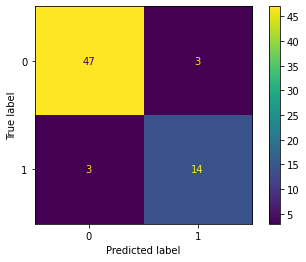

In [83]:
plot_confusion_matrix(rf_clf, X_test, y_test)

#### These are pretty good results! But let's use cross validation to see if these results hold up.

In [87]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline

In [94]:
def run_cfv(model, X, y, stratify=True):
    pipe = make_pipeline(model)
    cv = None
    if stratify:
        cv = StratifiedKFold(n_splits=5, random_state=44, shuffle=True)
    
    score_types = {'Accuracy':'accuracy', 'Recall':'recall', 'F1':'f1'}
       
    for name, score in score_types.items():
        cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring=score)
        print(f'{name} scores: {cv_scores}')
        print(f'\t{name} mean: {cv_scores.mean()}')
    

In [104]:
rf_clf2 = RandomForestClassifier(random_state=17)
run_cfv(rf_clf2, X, y, stratify=True)

Accuracy scores: [0.92537313 0.86567164 0.86567164 0.90909091 0.86363636]
	Accuracy mean: 0.8858887381275441
Recall scores: [0.82352941 0.64705882 0.64705882 0.88235294 0.58823529]
	Recall mean: 0.7176470588235294
F1 scores: [0.84848485 0.70967742 0.70967742 0.83333333 0.68965517]
	F1 mean: 0.7581656385883304


#### It holds up well! But wait, I forgot to drop the 'part-time' col...

In [105]:
# whoops, forgot to drop a col
X2 = X.drop('I am currently employed at least part-time', axis=1)

In [106]:
run_cfv(rf_clf2, X2, y, stratify=True)

Accuracy scores: [0.79104478 0.86567164 0.80597015 0.78787879 0.8030303 ]
	Accuracy mean: 0.8107191316146538
Recall scores: [0.35294118 0.58823529 0.29411765 0.35294118 0.35294118]
	Recall mean: 0.3882352941176471
F1 scores: [0.46153846 0.68965517 0.43478261 0.46153846 0.48      ]
	F1 mean: 0.5055029408372738
